In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('/kaggle/input/political-sentiment/PS_train.csv')

In [3]:
df_train[:5]

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


In [4]:
df_val = pd.read_csv('/kaggle/input/political-sentiment/PS_dev.csv')

In [5]:
df_val[:5]

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [6]:
df_train = df_train.dropna()
df_val = df_val.dropna()

In [7]:
train_label_counts = df_train['labels'].value_counts()
print(train_label_counts)

labels
Opinionated          1361
Sarcastic             790
Neutral               637
Positive              575
Substantiated         412
Negative              406
None of the above     171
Name: count, dtype: int64


In [8]:
val_label_counts = df_val['labels'].value_counts()
print(val_label_counts)

labels
Opinionated          153
Sarcastic            115
Neutral               84
Positive              69
Substantiated         52
Negative              51
None of the above     20
Name: count, dtype: int64


In [9]:
df_merged = pd.concat([df_train, df_val], axis=0)

In [10]:
x_train = df_merged['content']
x_val = df_val['content']

In [11]:
replace_values = {
    "Opinionated" : 0,
    "Sarcastic" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Substantiated" : 4,
    "Negative" : 5,
    "None of the above" : 6
}

In [12]:
y_train = df_merged['labels'].replace(replace_values)
y_val = df_val['labels'].replace(replace_values)

<ipython-input-12-3800ea415c6b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df_merged['labels'].replace(replace_values)
<ipython-input-12-3800ea415c6b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = df_val['labels'].replace(replace_values)


In [15]:
y_train.value_counts()

labels
0    1514
1     905
2     721
3     644
4     464
5     457
6     191
Name: count, dtype: int64

In [16]:
y_val.value_counts()

labels
0    153
1    115
2     84
3     69
4     52
5     51
6     20
Name: count, dtype: int64

In [18]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [20]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_val = vectorizer.transform(x_val)

In [21]:
model_dt = DecisionTreeClassifier(random_state=42)  # Decision Tree
model_svm = SVC(kernel='linear', probability=True, random_state=42)  # SVM with probability for soft voting
model_nb = MultinomialNB()  # Naive Bayes
model_knn = KNeighborsClassifier()  # K-Nearest Neighbors
model_lr = LogisticRegression(max_iter=1000, random_state=42)  # Logistic Regression

In [22]:
# Creating the Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('dt', model_dt),
        ('svm', model_svm),
        ('nb', model_nb),
        ('knn', model_knn),
        ('lr', model_lr)
    ],
    voting='soft'  # Use 'soft' voting to consider predicted probabilities
)
voting_model

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                             ('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('nb', MultinomialNB()),
                             ('knn', KNeighborsClassifier()),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [24]:
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                             ('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('nb', MultinomialNB()),
                             ('knn', KNeighborsClassifier()),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Testing data

In [27]:
df_test = pd.read_csv('/kaggle/input/political-sentiment/PS_test.csv')

In [28]:
df_test[:5]

,Id,content,labels
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,Neutral
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,Negative
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,Substantiated
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",Positive
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,Positive


In [32]:
x_test = df_test['content'] 
y_test = df_test['labels'].replace(replace_values)

<ipython-input-32-41dd3bbc78d0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = df_test['labels'].replace(replace_values)


In [34]:
X_test = vectorizer.transform(x_test)

In [36]:
y_pred = voting_model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(7)]))

Accuracy: 0.3750
Precision: 0.3387
Recall: 0.3250
F1 Score: 0.3227

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.65      0.51       171
           1       0.39      0.33      0.36       106
           2       0.20      0.19      0.19        70
           3       0.36      0.28      0.31        75
           4       0.10      0.04      0.06        51
           5       0.16      0.07      0.09        46
           6       0.75      0.72      0.73        25

    accuracy                           0.38       544
   macro avg       0.34      0.33      0.32       544
weighted avg       0.34      0.38      0.35       544



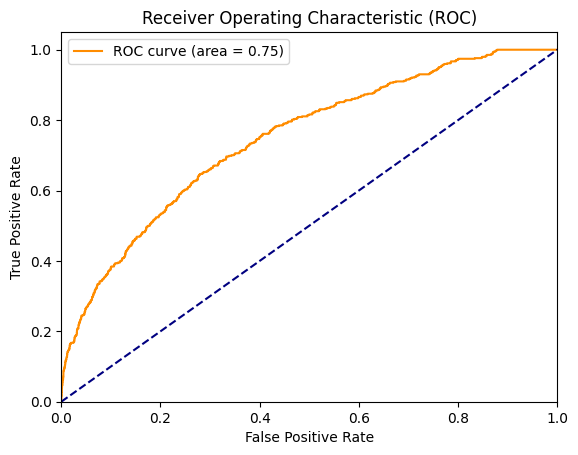

In [41]:
# ROC Curve
y_proba = voting_model.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

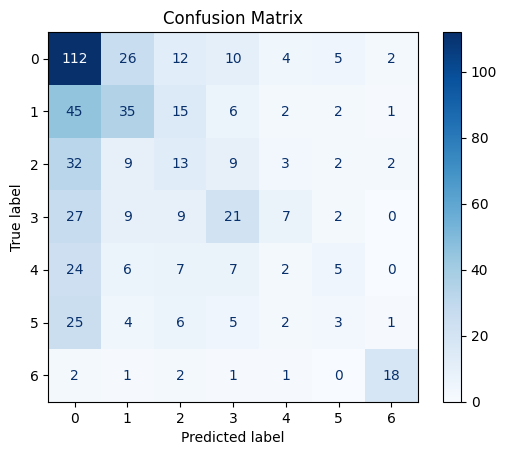

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()